# Redis Assignment

> Georgios Liargkovas | 8180061 | gliargovas@aueb.gr <br/>
> Georgios - Petros Drosos | 8180024 | t8180024@aueb.gr <br/>
> Big Data Management Systems Course 2022 <br/>
> Professor: Damianos Chatziantoniou <br/>

## Database Creation

* For the purpose of this assignment, we need to create a relational database
* We decided to store our data in an SQLite database, because it is a reliable, portable and easy-to-use database
* We do not need to install SQLite, since it is included in the Python Standard Library

In [ ]:
import sqlite3

* We the following method, we connect to the database

In [ ]:
def get_db_connection():
    conn = sqlite3.connect('database.db', check_same_thread=False, isolation_level=None)
    return conn

## Database Schema


* Our database consists of the 5 following tables, as described on the assignment:

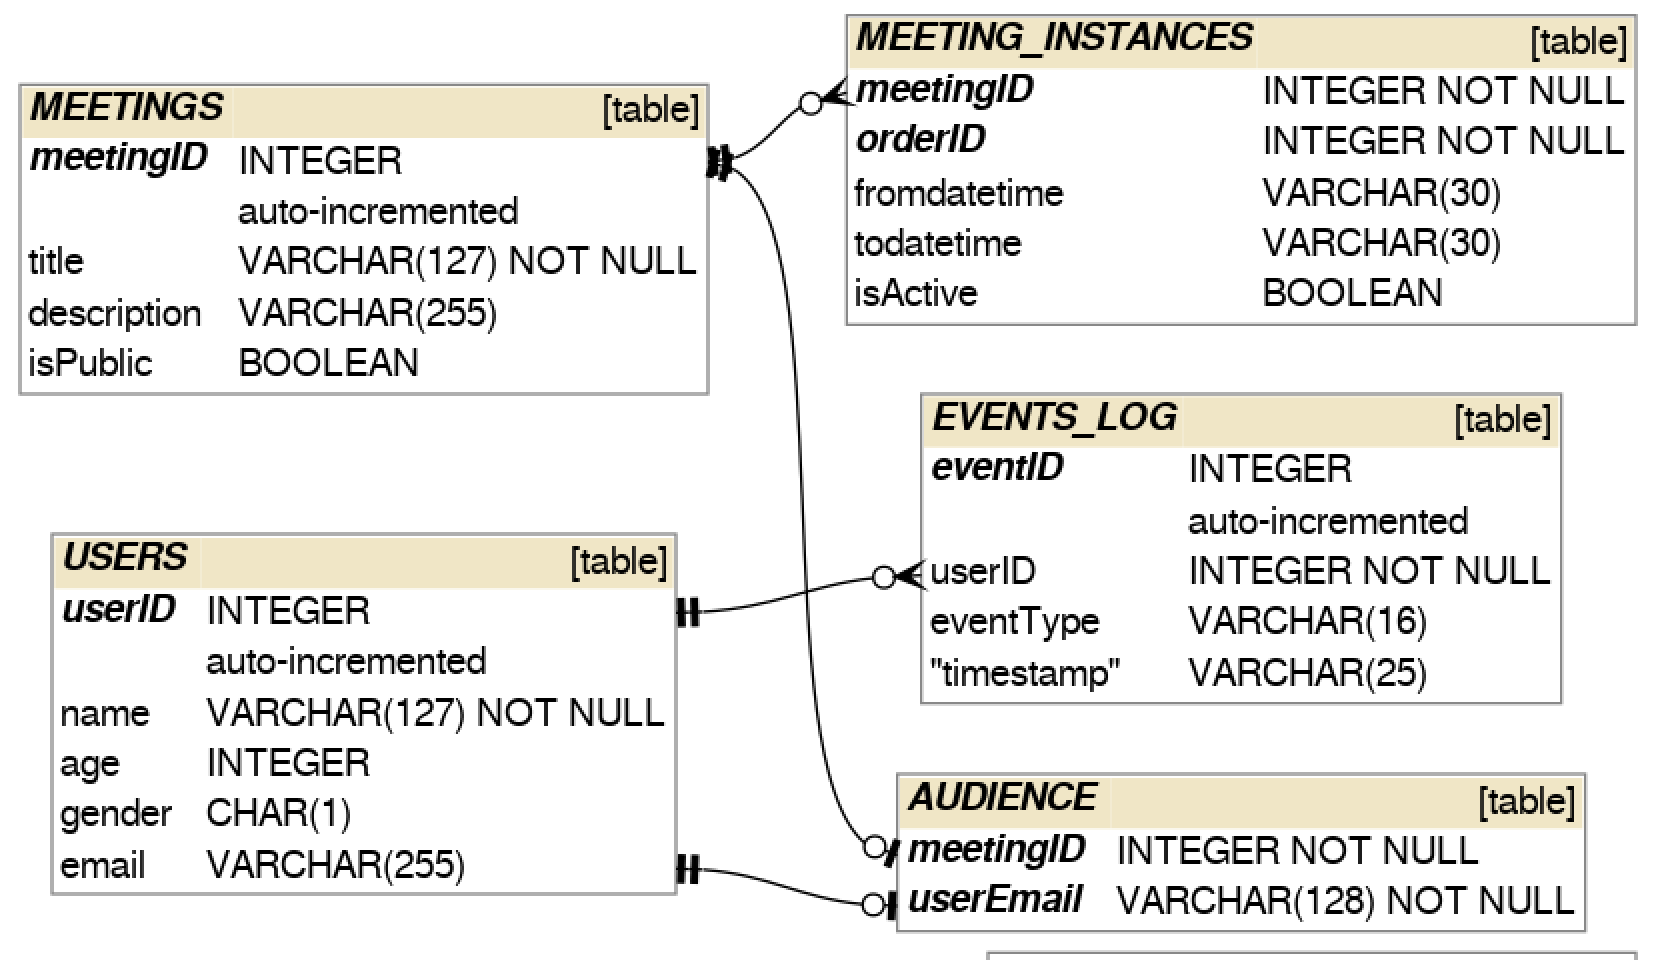

INFO:root:activating meeting meeting:15:2
INFO:root:activating meeting meeting:15:11
INFO:root:activating meeting meeting:16:2
INFO:root:activating meeting meeting:17:11
INFO:root:activating meeting meeting:18:2
INFO:root:activating meeting meeting:19:11
INFO:root:activating meeting meeting:14:5
INFO:root:activating meeting meeting:14:6
INFO:root:activating meeting meeting:15:2
INFO:root:activating meeting meeting:15:11
INFO:root:activating meeting meeting:16:2
INFO:root:activating meeting meeting:17:11
INFO:root:activating meeting meeting:18:2
INFO:root:activating meeting meeting:19:11
INFO:root:activating meeting meeting:14:5
INFO:root:activating meeting meeting:14:6
INFO:root:activating meeting meeting:15:2
INFO:root:activating meeting meeting:15:11
INFO:root:activating meeting meeting:16:2
INFO:root:activating meeting meeting:17:11
INFO:root:activating meeting meeting:18:2
INFO:root:activating meeting meeting:19:11
INFO:root:activating meeting meeting:14:5
INFO:root:activating meet

In [23]:
from IPython.display import Image
Image(filename='img/db_schema.png') 


* The SQL statements used to create our database schema are shown bellow:

``` mysql
CREATE TABLE USERS (
    userID INTEGER PRIMARY KEY AUTOINCREMENT,
    name VARCHAR(127) NOT NULL,
    age INTEGER,
    gender CHAR(1),
    email VARCHAR(255)
);

CREATE TABLE MEETINGS (
    meetingID INTEGER PRIMARY KEY AUTOINCREMENT,
    title VARCHAR(127) NOT NULL,
    description VARCHAR(255),
    isPublic BOOLEAN
);

CREATE TABLE AUDIENCE (
    meetingID INTEGER NOT NULL,
    userEmail VARCHAR(128) NOT NULL,
    PRIMARY KEY(meetingID, userEmail)
    FOREIGN KEY(meetingID) REFERENCES MEETINGS(meetingID)
    FOREIGN KEY(userEmail) REFERENCES USERS(email)
);

CREATE TABLE MEETING_INSTANCES (
    meetingID INTEGER NOT NULL,
    orderID INTEGER NOT NULL,
    fromdatetime VARCHAR(30),
    todatetime VARCHAR(30),
    isActive BOOLEAN,
    PRIMARY KEY(meetingID, orderID)
    FOREIGN KEY(meetingID) REFERENCES MEETINGS(meetingID)
);
```

## Database Population

* In order to test our program, we need to fill our tables with dummy data.
* An example table population is shown bellow:


``` 
INSERT INTO EVENTS_LOG(eventID, userID, eventType, timestamp)
VALUES
    (1,1,'join',1652084078),
    (2,1,'leave',1652084088), 
    (3,2,'join',1652084078),
    (4,2,'leave',1652084178)
```

* All the insertions querries can be found on the [appendix](#appendix)

# Redis Connection

* In order to connect to redis, we need to install the corresponding library for python, using the python package manager
  

In [ ]:
!pip install redis

* Then, we can create a connection to redis on our localhost 

In [ ]:
import redis

def get_redis_connection():
    return redis.Redis('localhost', port=6379, decode_responses=True)


# Load Database to Redis

* For the purpose of this assignment, we need to load the contents of our database into redis


In [ ]:

def load_db_to_redis():
    # empty all contents previously stored after init
    cache = utils.get_redis_connection()
    cache.flushdb()
    conn = utils.get_db_connection()
    cursor_obj = conn.cursor()
    try:
        # load users to redis
        users = cursor_obj.execute("SELECT * FROM USERS").fetchall()
        for userID, name, age, gender, email in users:
            cache.hmset(f'user:{userID}', {
                "id": userID,
                "name": name,
                "age": age,
                "gender": gender,
                "email": email
            })
        users = None
        # load events to redis

        max_id = 0
        logs = cursor_obj.execute("SELECT * FROM EVENTS_LOG").fetchall()
        for eventID, userID, eventType, timestamp in logs:
            if int(eventID) > max_id:
                max_id = int(eventID)
            cache.hmset(f'log:{eventID}', {
                "eventID": eventID,
                "userID": userID,
                "eventType": eventType,
                "timestamp": timestamp
            })
        logs = None
        cache.set("log_count", str(max_id + 1))
    except Exception as exc:
        logging.critical(exc)
    finally:
        cache.close()
        conn.close()

More specifically:

* We store the user attributes in a `user:{userID}` key:

``` json
user:{userID}, {
                "id": userID,
                "name": name,
                "age": age,
                "gender": gender,
                "email": email
            }
```

* We store the event attributes in a `log:{eventID}` key:

``` json
log:{eventID}, {
                "eventID": eventID,
                "userID": userID,
                "eventType": eventType,
                "timestamp": timestamp
            })
```

* We did not store the contents of the other tables on redis during  the initialization, because they will be stored dynamically after the triggering of some events

# Design Directive

* We decided to create a restful application through flask in order to present each function in a more beautiful and concrete way
* We created the application with the help of the flask library

In [ ]:
!pip install flask

In [ ]:
from datetime import datetime
from flask import Flask, render_template
import logging
from apscheduler.schedulers.background import BackgroundScheduler
import utils
import initialize


cache = utils.get_redis_connection()

app = Flask(__name__)
logging.basicConfig(level=logging.INFO)
logging.info("Hello!")
initialize.init_sqlite_db()
initialize.load_db_to_redis()


@app.route('/')
def index():
    return render_template('index.html', posts=["Hello"])

## Function: a meeting instance becomes active

* In order to activate our meetings, we employ the `activate_meetings()` method which is triggered 4 seconds after the applicaton starts
* At first we retrieve the attributes of the meeting instances along with the meetings
* We convert the type of the time atributes from timestamp to datetime
*  We create a meeting signature which is formed by the `meeting_id` and the `order_id`
*  We check whether this meeting is active by checking whether its signatures is included in the redis set of `active_meetings`
*  If the meeting instance is not active, we check whether the current date is between the start and the end date of this instance
*  If this is the case, we activate the meeting by adding its meeting signature to the `active_meetings` set and by adding its attributes to a redis set having as key its signature. 
*  If the meeting instance is not public, we also retrieve the emails of the audience of this specific meeting and we store them in a redis set having a key of the format: `{meeting_signature}:audience`
  ------
*  If this is the case, if its end date has passed, we deactivate it by removing it from the redis set of active meetings
*  Then we remove also from redis its meeting information and the meeting audience TODO

In [ ]:
def activate_meetings():
    try:
        cursor_obj = conn.cursor()
        current_time = datetime.now()
        meetings = cursor_obj.execute("""
        SELECT m.meetingID, i.orderID, m.title, m.description, m.isPublic, fromdatetime, todatetime
        FROM MEETINGS as m, MEETING_INSTANCES as i
        WHERE m.meetingID = i.meetingID
        """).fetchall()
        for meetingID, orderID, title, description, isPublic, from_dt, to_dt in meetings:
            if "." in from_dt:
                time_string = r'%d-%m-%Y %H:%M:%S.%f'
            else:
                time_string = r'%d-%m-%Y %H:%M:%S'
            start = datetime.strptime(from_dt, time_string)
            end = datetime.strptime(to_dt, time_string)
            meeting_signature = f'meeting:{meetingID}:{orderID}'

            if cache.sismember('active_meetings', meeting_signature):
                if current_time > end:
                    logging.info(f"deactivating meeting {meeting_signature}")

                    # REMOVE FROM ACTIVE MEETINGS
                    cache.srem('active_meetings', meeting_signature)

                    # REMOVE MEETING INFO AND AUDIENCE
                    cache.delete(meeting_signature)
                    cache.delete(f'{meeting_signature}:audience')

                    # REMOVE MEETING MESSAGES
                    for key in cache.scan_iter(f'message:{meetingID}:*'):
                        cache.delete(key)
                    cache.delete(f'{meeting_signature}:messages')

                    # REMOVE JOINED MEMBERS
                    joined = cache.smembers(f'{meeting_signature}:joined')
                    for userID in joined:
                        cursor_obj.execute(f"""
                        INSERT INTO EVENTS_LOG (userID, eventType, timestamp)
                        VALUES ({userID}, "leave", '{str(end)}')
                        """)
                    cache.delete(f'{meeting_signature}:joined')

                    # DELETE LOGS
                    logs = cache.smembers(f'{meeting_signature}:logs')
                    for eventID in logs:
                        userID, eventType, timestamp = cache.hmget(
                            f'log:{eventID}', ["userID", "eventType", "timestamp"])

                        cursor_obj.execute(f"""
                        INSERT INTO EVENTS_LOG (userID, eventType, timestamp)
                        VALUES ({userID}, "{eventType}", "{timestamp}")
                        """)
                        conn.commit()
                        cache.delete(f'log:{eventID}')
                    cache.delete(f'{meeting_signature}:logs')
            else:
                if start < current_time < end:
                    logging.info(f"activating meeting {meeting_signature}")
                    cache.sadd('active_meetings', meeting_signature)
                    cache.hmset(meeting_signature, {
                        "meetingID": meetingID,
                        "orderID": orderID,
                        "title": title,
                        "description": description,
                        "isPublic": isPublic,
                        "fromdatetime": str(start),
                        "todatetime": str(end)
                    })

                    if not isPublic:
                        audience = cursor_obj.execute(f"""
                        SELECT userEmail
                        FROM MEETINGS as m, AUDIENCE as a
                        WHERE m.meetingID = {meetingID}
                        AND m.meetingID = a.meetingID
                        """).fetchall()
                        for email in audience:
                            cache.sadd(
                                f'{meeting_signature}:audience', email[0])
    except Exception as e:
        traceback.print_exc()

In [ ]:

scheduler = BackgroundScheduler()
scheduler.add_job(func=utils.activate_meetings, trigger="interval", seconds=4)
logging.getLogger('apscheduler.executors.default').setLevel(logging.WARNING)
scheduler.start()

## Function: a user joins an active meeting instance – if allowed, i.e. his email is in audience

* We created an API endpoint with the form of `/join_meeting/<meeting_signature>/<user_id>` in order to triger our app when an user (with a user_id wants to join a specific meeting instance)
* At first we need to check if the specific user exists in our database. We assume that users not existing in our database are unregistered and therefore cannot access the meetings
* We validate their existense by checking whether they have an email key in the redis `user:{userID}`set.
* Then, we check if the specific meeting is active by searching the meeting signature in the `active_meetings`set
* If the meeting is active, we check whether it has audience and whether the specifi email is in audience
* If this is the case, the user can join the specfic meeting instance
* Consequently, we add his id to the `meeting:{meeting_signature}:joined` set, in order to track the users in each meeting.
* We also have a redis set with the logs of specific events, in the form of:
  ``` json 
  log:{id}, {
                    "eventID": {eventID},
                    "userID": {user_id},
                    "eventType": "join/leave",
                    "timestamp": {dateTime}
                }
  ```
  Note: The log id is auto-incrementing
* Therefore, we need to create a new log with the date of this event, having an eventType as join 
* If the user is not allowed to join the meeting or if the meeting is not active, we show an error message in a corresponding page.

In [ ]:
def resolve_user_email(userID):
    result = cache.hmget(f"user:{userID}", "email")
    if result[0] is None:
        raise Exception("user does not exist")
    return result[0]

In [ ]:
@app.route('/join_meeting/<meeting_signature>/<user_id>', methods=["GET"])
def join_meeting(meeting_signature, user_id):
    try:
        email = resolve_user_email(user_id)
        # at first we check if a meeting is active
        if cache.sismember("active_meetings", f"meeting:{meeting_signature}"):
            # if a meeting has an audience, then the email should be in the audience set
            if (not cache.exists(f"meeting:{meeting_signature}:audience")) or cache.sismember(f"meeting:{meeting_signature}:audience", email):
                count = cache.get("log_count")
                cache.sadd(f"meeting:{meeting_signature}:joined", user_id)
                cache.hmset(f'log:{count}', {
                    "eventID": count,
                    "userID": user_id,
                    "eventType": "join",
                    "timestamp": datetime.now().strftime(r'%d-%m-%Y %H:%M:%S.%f')
                })
                cache.sadd(f"meeting:{meeting_signature}:logs", count)
                cache.incr("log_count")
            else:
                raise Exception(
                    f"email {email} is not allowed into the meeting!")
        else:
            raise Exception(
                f"meeting with signature {meeting_signature} not active!")
        return render_template('index.html', posts=[f"Success!"])
    except Exception as e:
        logging.error(f"Error: {str(e)}")
        return render_template('index.html', posts=[f"Error:{str(e)}"])

## Function: a user leaves a meeting that has joined

* In order for an user to reave a meeting instance, we first need to check whether he has an email
* If this is the case, we remove his id from the redis set `meeting:{meeting_signature}:joined`
* We also need to update the log set with this event
* If his id is not in the `meeting:{meeting_signature}:joined` set (meaning that he has not joined the meeting), or if the  set `meeting:{meeting_signature}:joined` does not exist (meaning that the meeting instance is not active), we show an error message in a corresponding page. 

In [ ]:

# Function: a user leaves a meeting that has joined
@app.route('/leave_meeting/<meeting_signature>/<user_id>', methods=["GET"])
def leave_meeting(meeting_signature, user_id):
    try:
        email = resolve_user_email(user_id)
        try:
            remove_stmt = cache.srem(
                f"meeting:{meeting_signature}:joined", user_id)
            count = cache.get("log_count")
            cache.hmset(f'log:{count}', {
                "eventID": count,
                "userID": user_id,
                "eventType": "leave",
                "timestamp": datetime.now().strftime(r'%d-%m-%Y %H:%M:%S.%f')
            })
            cache.incr("log_count")
        except:
            raise(
                Exception(f"meeting with signature {meeting_signature} is not active!"))
        if remove_stmt:
            return render_template('index.html', posts=[f"Success!"])
        else:
            raise Exception(
                f"user with email {email} is not found in the audience!")
    except Exception as e:
        logging.error(f"Error: {str(e)}")
        return render_template('index.html', posts=[f"Error:{str(e)}"])

##  Function: show meeting’s current participants

* We need to retrieve the set of user ids in the redis `meeting:{meeting_signature}:joined` key
* If the meeting has at least one participant, we return a list with all the user ids
* If the meeting is  inactive or does not exist, we show an error message in a corresponding page. 

In [ ]:

# Function: show meeting’s current participants
@app.route('/show_participants/<meeting_signature>', methods=["GET"])
def show_meeting_participants(meeting_signature):
    try:
        stmt = cache.smembers(f"meeting:{meeting_signature}:joined")
        print(stmt)
        if len(stmt) >= 0:
            result = "["
            for user in stmt:
                result += str(cache.hgetall(f"user:{user}")) + ","
            result = result[:-1] + "]"
    
            return utils.format_results(result)
        else:
            raise Exception(f"meeting is either inactive or does not exist!")
    except Exception as e:
        return render_template('index.html', posts=[f"Error:{str(e)}"])

## Function: show active meetings

* In order to show the active meetings, we retrieve the members (meeting instances) of the `active_meetings` redis key, which is populated whether a meeting becomes activated.
* For each meeting instance, we retrieve from redis its information which is stored on a `{meeting_instance}` key and we return a list with all the information for each active meeting.
* If there are no active meetings, we show an error message in a corresponding page. 

In [ ]:

# Function: show active meetings
@app.route('/active_meetings/', methods=["GET"])
def show_active_meetings():
    try:
        stmt = cache.smembers("active_meetings")
        results = []
        if len(stmt) > 0:
            for element in stmt:
                results.append(cache.hgetall(f"{element}"))
            return utils.format_results(results)
        else:
            return render_template('index.html', posts=[f"There are no active meetings!"])
    except Exception as e:
        logging.error(f"Error:{str(e)}")
        return render_template('index.html', posts=[f"Error:{str(e)}"])

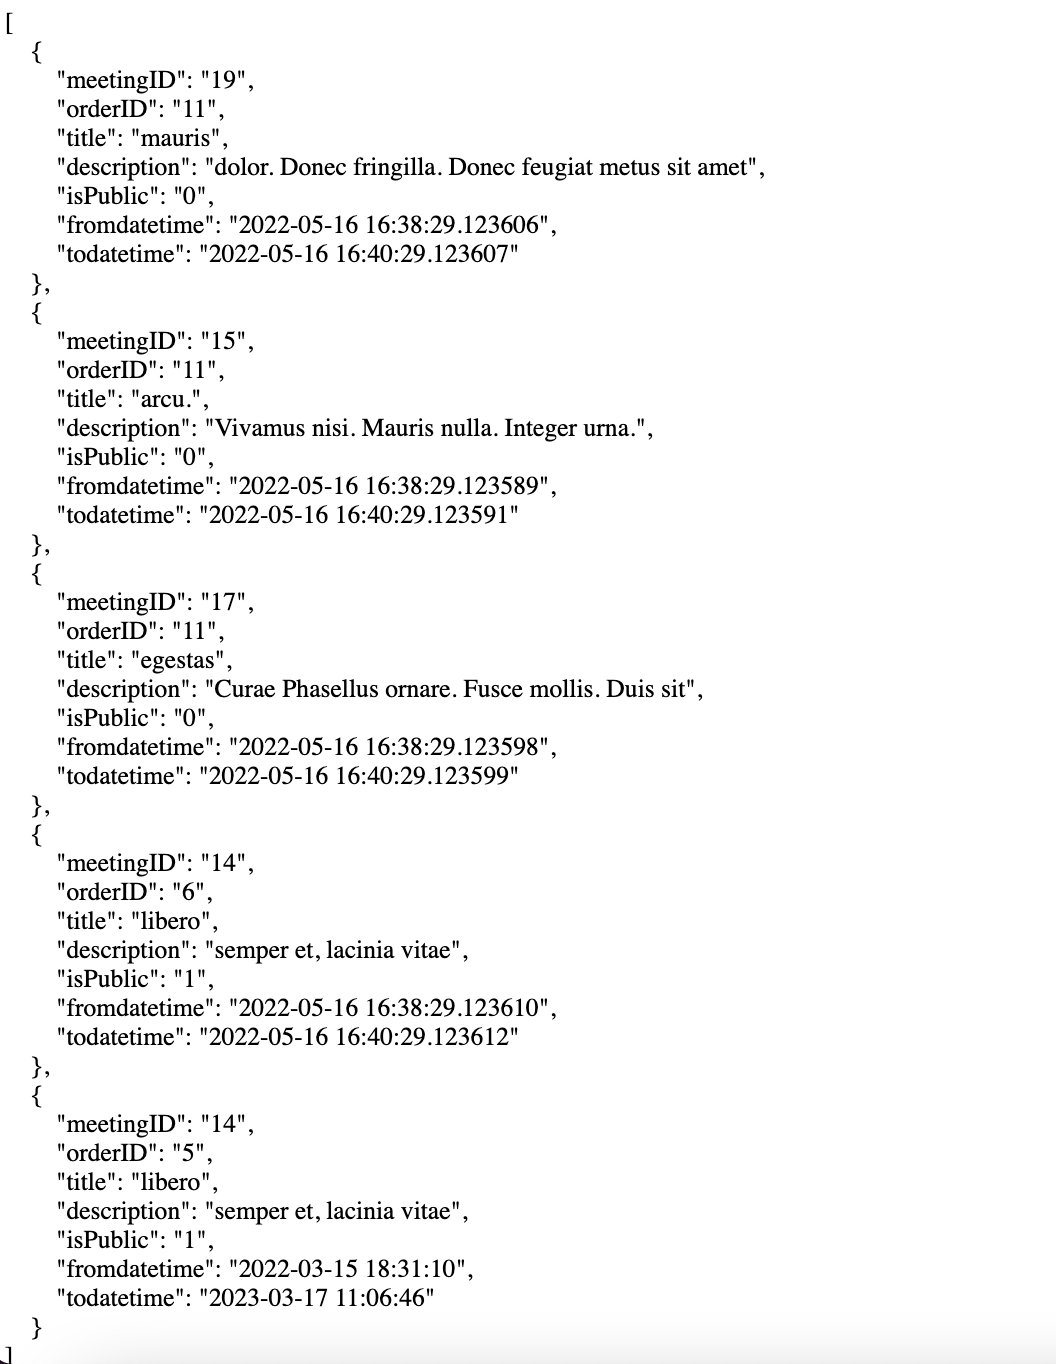

In [24]:
Image(filename='img/show_active_meetings.png') 

## Function: a user can posts a chat message

* For this function we created an API endpoint in the format of `/post_message/<meeting_signature>/<user_id>/<text>` specifying that an user with a `<user_id>` posts a message (`<text>`) in a meeting instance.

* We first check whether the user_id corresponds to an existing user with an email.
* If the meeting is active (meaning that the signature exists in the `active_meetings` redis set)
* and if the user has joined the meeting (meaning that the user_id exists in the 
  `meeting:{meeting_signature}:messages` redis set):
* We add the text of the message to a set on redis having the `meeting:{meeting_signature}:messages` as key in order to be able to retrieve the messages of the specfiic meeting signature
* We also add the text of the message to a set on redis having the `meeting:{meeting_signature}:{user_id}` as key in order to be able to retrieve the messages of the specfiic user
* If the meeting is not active, or if the user has either not joined the meeting or he is not allowed to join, we show an error message in a corresponding page.

In [ ]:
@app.route('/post_message/<meeting_signature>/<user_id>/<text>', methods={"GET"})
def post_message(meeting_signature, user_id, text):
    try:
        email = resolve_user_email(user_id)
        # at first we check if a meeting is active
        if cache.sismember("active_meetings", f"meeting:{meeting_signature}"):
            if cache.sismember(f"meeting:{meeting_signature}:joined", user_id):
                cache.rpush(f"meeting:{meeting_signature}:messages", text)
                cache.rpush(f"message:{meeting_signature}:{user_id}", text)
                return render_template('index.html', posts=[f"Success!"])
            else:
                raise Exception(
                    f"user with email {email} hasn't joined the meeting or is not allowed into the meeting!")
        else:
            raise Exception(
                f"meeting with signature {meeting_signature} not active!")
    except Exception as e:
        logging.error(f"Error: {str(e)}")
        return render_template('index.html', posts=[f"Error:{str(e)}"])


<a id='appendix'></a>
# Appendix
## Insertion SQL Querries

``` mysql
INSERT INTO USERS (userID, name, age, gender, email)
    VALUES
        ("1","Scott Compton",84,"M","pede.suspendisse@hotmail.ca"),
        ("2","Kasper Dixon",18,"M","mollis.lectus@hotmail.edu"),
        ("3","Iliana Hancock",75,"M","mi.pede@aol.couk"),
        ("4","Sade Guzman",40,"M","mi.ac.mattis@outlook.net"),
        ("5","Avram Anderson",44,"F","amet.consectetuer.adipiscing@google.org"),
        (6,"Carol Medina",83,"M","magna.malesuada.vel@hotmail.couk"),
        (7,"Yuli Dillon",54,"F","tempor.est.ac@yahoo.edu"),
        (8,"Alyssa Quinn",38,"M","tempus.risus@aol.ca"),
        (9,"Lars Hatfield",81,"F","elit.fermentum.risus@google.com"),
        (10,"Zorita Mason",18,"M","ultrices.vivamus@hotmail.com"),
        (11,"Kennedy Cross",73,"F","ante.dictum@aol.edu"),
        (12,"Ella Barr",52,"F","ut@outlook.edu"),
        (13,"Nora Henderson",85,"F","aenean.eget@icloud.org"),
        (14,"Maggie Church",33,"M","dolor.sit@google.net"),
        (15,"Christian Hart",28,"F","consectetuer.adipiscing@icloud.couk"),
        (16,"Coby Hall",25,"F","tempus@google.couk"),
        (17,"Ahmed Chandler",44,"F","aenean.eget@icloud.com"),
        (18,"Hector Dixon",50,"M","vel.pede@outlook.org"),
        (19,"Ima Johnston",83,"M","tristique.pharetra.quisque@icloud.couk"),
        (20,"Hop Chase",76,"F","id.mollis.nec@hotmail.net");

INSERT INTO MEETINGS (meetingID,title,description,isPublic)
    VALUES
        (10,"ullamcorper","velit justo nec ante. Maecenas","0"),
        (11,"fringilla","sapien imperdiet ornare.","0"),
        (12,"ipsum","Praesent eu nulla at sem molestie sodales. Mauris","0"),
        (13,"auctor,","vulputate dui", "0"),
        (14,"libero","semper et, lacinia vitae", "1"),
        (15,"arcu.","Vivamus nisi. Mauris nulla. Integer urna.","0"),
        (16,"ligula.","montes, nascetur", "0"),
        (17,"egestas","Curae Phasellus ornare. Fusce mollis. Duis sit","0"),
        (18,"natoque","pede. Praesent eu","0"),
        (19,"mauris","dolor. Donec fringilla. Donec feugiat metus sit amet","0"),
        (20,"Curabitur","et pede.","0"),
        (21,"adipiscing","et pede. Nunc sed orci lobortis augue scelerisque mollis.","1"),
        (22,"sit","Aliquam ornare, libero at auctor ullamcorper", "1"),
        (23,"tempor","amet metus. Aliquam erat volutpat. Nulla facilisis. Suspendisse commodo","1"),
        (24,"sodales","a neque. Nullam ut nisi a odio","1"),
        (25,"vestibulum,","pellentesque","1"),
        (26,"eget","nisl sem, consequat nec","1"),
        (27,"Proin","Nulla facilisi. Sed neque. Sed eget","1"),
        (28,"tortor","neque. Sed eget lacus. Mauris non","1"),
        (29,"neque.","senectus et netus et malesuada","1");

    INSERT INTO AUDIENCE (meetingID,userEmail)
    VALUES
        (13,"pede.suspendisse@hotmail.ca"),
        (17,"pede.suspendisse@hotmail.ca"),
        (12,"pede.suspendisse@hotmail.ca"),
        (15,"dolor.sit@google.net"),
        (17,"dolor.sit@google.net"),
        (15,"id.mollis.nec@hotmail.net"),
        (14,"id.mollis.nec@hotmail.net"),
        (16,"id.mollis.nec@hotmail.net");

    meeting_instances_insert = f"""INSERT INTO MEETING_INSTANCES (meetingID,orderID,fromdatetime, todatetime, isActive)
    VALUES
    (15,1,"25-07-2022 09:33:13","25-07-2023 10:33:13",0),
    (15,2,"{datetime.datetime.now().strftime(r'%d-%m-%Y %H:%M:%S.%f')}","{(datetime.datetime.now() + datetime.timedelta(seconds=12)).strftime(r'%d-%m-%Y %H:%M:%S.%f')}",0),
    (15,11,"{datetime.datetime.now().strftime(r'%d-%m-%Y %H:%M:%S.%f')}","{(datetime.datetime.now() + datetime.timedelta(seconds=120)).strftime(r'%d-%m-%Y %H:%M:%S.%f')}",0),
    (44,2,"15-03-2022 18:31:10","07-05-2023 05:40:24",0),
    (55,2,"15-03-2022 18:31:10","07-05-2023 05:40:24",0),
    (66,2,"15-03-2022 18:31:10","07-05-2023 05:40:24",0),
    (77,3,"15-03-2022 18:31:10","05-06-2023 05:15:06",0),
    (88,4,"02-06-2022 06:07:34","02-06-2023 07:07:34",0),
    (14,5,"15-03-2022 18:31:10","17-03-2023 11:06:46",0),
    (14,6,"31-01-2022 11:33:33","31-01-2023 12:33:33",0),
    (14,7,"07-07-2022 03:56:31","07-07-2023 04:56:31",0),
    (14,8,"15-03-2022 18:31:10","14-05-2022 06:30:41",0),
    (14,9,"27-01-2022 03:21:48","27-01-2022 04:21:48",0),
    (14,10,"22-02-2022 10:28:25","22-02-2022 11:28:25",0),
    (16,11,"23-05-2022 01:45:10","23-05-2022 02:45:10",0),
    (17,12,"07-04-2022 12:40:18","07-04-2022 13:40:18",0),
    (18,13,"28-05-2022 06:31:03","28-05-2022 07:31:03",0),
    (15,14,"03-04-2022 02:02:56","03-04-2022 03:02:56",0),
    (19,15,"26-02-2022 01:20:00","26-02-2022 02:20:00",0),
    (10,16,"16-05-2022 12:49:04","16-05-2022 13:49:04",0),
    (10,17,"10-01-2022 10:35:45","10-01-2022 11:35:45",0),
    (10,18,"14-06-2022 04:43:12","14-06-2022 05:43:12",0),
    (11,19,"24-07-2022 02:11:14","24-07-2022 03:11:14",0),
    (10,20,"03-03-2022 11:38:19","03-03-2022 12:38:19",0);
    
INSERT INTO EVENTS_LOG(eventID, userID, eventType, timestamp)
VALUES
    (1,1,'join',1652084078),
    (2,1,'leave',1652084088), 
    (3,2,'join',1652084078),
    (4,2,'leave',1652084178);
```